# stackview
Interactive image stack viewing in jupyter notebooks based on 
[ipycanvas](https://ipycanvas.readthedocs.io/) and 
[ipywidgets](https://ipywidgets.readthedocs.io/en/latest/).

## Usage
You can use `stackview` from within jupyter notebooks as shown below.

Starting point is a 3D image dataset provided as numpy array. 

In [1]:
import stackview
stackview.__version__

'0.16.0'

In [2]:
import numpy as np
from imageio.v3 import imread
from skimage.filters import gaussian

In [3]:
image = imread('https://github.com/haesleinhuepf/stackview/blob/main/docs/data/Haase_MRT_tfl3d1.tif?raw=true', plugin='tifffile')

## Slice
You can then view it slice-by-slice:

In [4]:
image[:3].shape

(3, 160, 160)

In [5]:
stackview.slice(image[:3], continuous_update=True)

# Insight
You can also get a static view using a maximum-intensity projection with additional information.


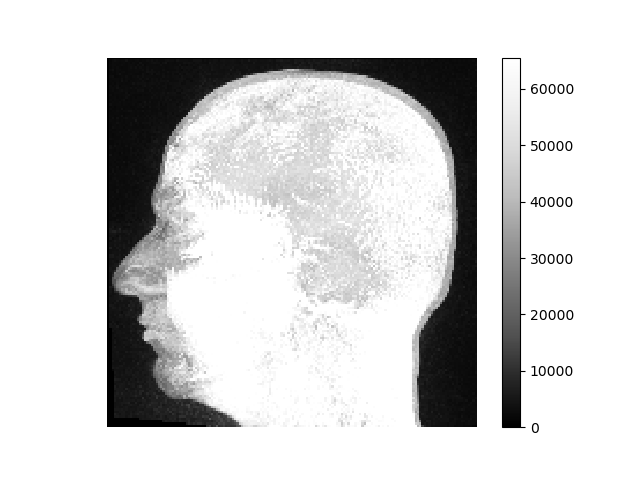
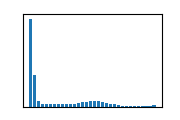

shape (120, 160, 160) 
 dtype uint16 
 size 5.9 MB 
 min 0 max 65535
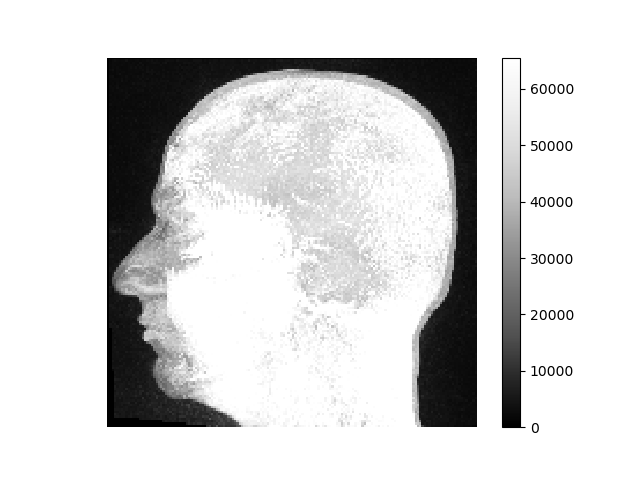
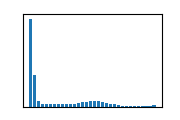

In [6]:
stackview.insight(image)

# Annotate
To draw label images, use `annotate`.

In [7]:
import numpy as np
labels = np.zeros(image.shape).astype(np.uint32)

stackview.annotate(image, labels)

## Picker
To read the intensity of pixels where the mouse is moving, use the picker.

In [8]:
stackview.picker(image, continuous_update=True)

## Orthogonal
Orthogonal views are also available:

In [9]:
stackview.orthogonal(image, continuous_update=True)

## Curtain
For visualization of an original image in combination with a processed version, a curtain view may be helpful:

In [10]:
modified_image = image.max() - image

In [11]:
stackview.curtain(image, modified_image, continuous_update=True)

One can also use the curtain to visualize semantic segmentation results as label images.

In [12]:
labels = (image > 5000)*1 + (image > 15000)*1 + (image > 30000)*1

In [13]:
stackview.curtain(image, labels, continuous_update=True)

The curtain can also be partially transparent using the alpha value.

In [14]:
stackview.curtain(image, labels, continuous_update=True, alpha=0.3)

The curtain also works with 2D data

In [15]:
slice_image = imread('https://github.com/haesleinhuepf/stackview/blob/main/docs/data/blobs.tif?raw=true', plugin='tifffile')

In [16]:
from skimage.filters import threshold_otsu
binary = (slice_image > threshold_otsu(slice_image))

In [17]:
binary.shape, slice_image.shape

((254, 256), (254, 256))

In [18]:
stackview.curtain(slice_image, binary, continuous_update=True)

Also label images are supported. Images are shown as labels in case their pixel type is (unsigned) integer 32-bit or 32-bit.

In [19]:
from skimage.measure import label
labels = label(binary)

In [20]:
stackview.curtain(slice_image, labels, continuous_update=True)

## Side-by-side
A side-by-side view of two stacks is also available. It might be useful for colocalization visualization or showing subsequent time points of a timelapse.

In [21]:
image_stack = imread('https://github.com/haesleinhuepf/stackview/blob/main/docs/data/CalibZAPWfixed_000154_max.tif?raw=true', plugin='tifffile').swapaxes(1,2)

In [22]:
stackview.side_by_side(image_stack[1:], image_stack[:-1], continuous_update=True, display_width=300)

side_by_side


In [23]:
labels_stack = np.asarray([label(image > 100) for image in image_stack])

In [24]:
stackview.side_by_side(image_stack, labels_stack, continuous_update=True, display_width=300)

side_by_side


## Switch
If there are many images you would like to inspect, you can pass them as dictionary or list to `switch()`.

In [25]:
stackview.switch({
    "image":slice_image,
    "binary":binary,
    "labels":labels
})

In [26]:
stackview.switch([image_stack[1:], image_stack[:-1]])

In [27]:
stackview.switch([
    slice_image,
    binary,
    labels
])

In [28]:
hela_cells = imread("data/hela-cells.tif")
hela_cells.shape

(512, 672, 3)

In [29]:
stackview.switch(
    {"lysosomes":   hela_cells[:,:,0],
     "mitochondria":hela_cells[:,:,1],
     "nuclei":      hela_cells[:,:,2]
    },
    colormap=["pure_magenta", "pure_green", "pure_blue"],
    toggleable=True
)

## n-dimensional data

In [30]:
mitosis = imread("data/mitosis.tif")
stackview.switch(images=[
                    mitosis[:,:,0], # channel 1
                    mitosis[:,:,1]  # channel 2
                 ], 
                 colormap=[
                     "pure_green", 
                     "pure_magenta"
                 ], 
                 toggleable=True)

## Crop
The `crop` widget allows to crop the image in Z,Y and X.

In [31]:
crop_widget = stackview.crop(image_stack)
crop_widget

_Cropper(children=(HBox(children=(VBox(children=(VBox(children=(IntRangeSlider(value=(0, 100), description='Z'…

You can retrieve the range the user entered like this:

In [32]:
crop_widget.range

(slice(0, 100, 1), slice(0, 389, 1), slice(0, 235, 1))

You can also get the cropped image directly.


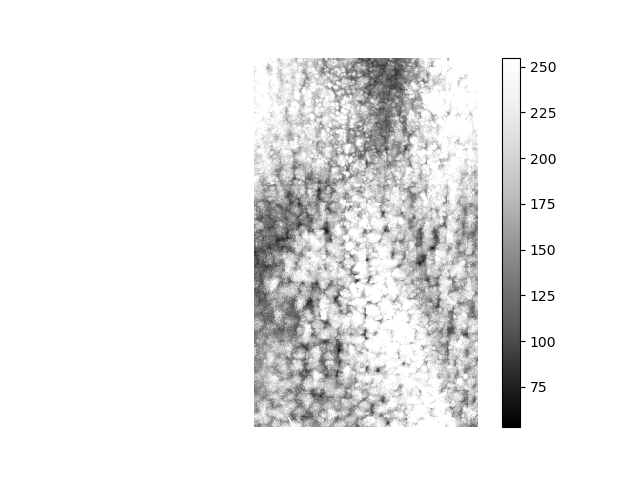
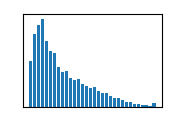

shape (100, 389, 235) 
 dtype uint8 
 size 8.7 MB 
 min 0 max 255
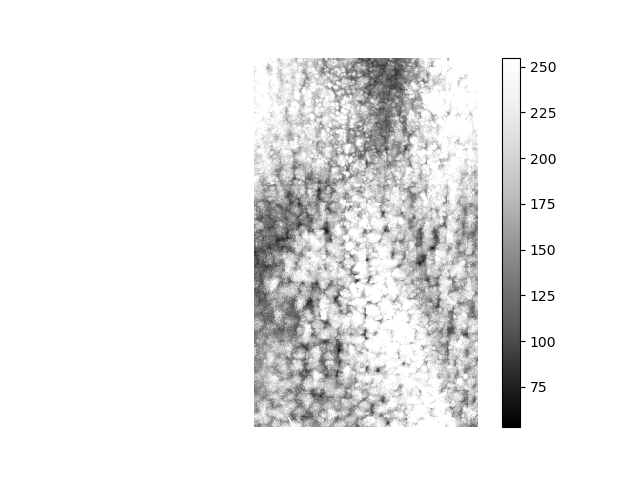
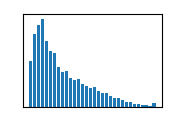

In [33]:
crop_widget.crop()

## Interact
You can also use `interact` to explore parameters of some supported functions that process images, e.g. from [scikit-image](https://scikit-image.org/):

In [34]:
from skimage.filters.rank import maximum
stackview.interact(maximum, slice_image)

In [35]:
from skimage.filters import gaussian
stackview.interact(gaussian, slice_image)

This might be interesting for custom functions executing image processing workflows.

In [36]:
from skimage.filters import gaussian, threshold_otsu, sobel
def my_custom_code(image, sigma:float = 1, show_labels: bool = True):
    sigma = abs(sigma)
    blurred_image = gaussian(image, sigma=sigma)
    binary_image = blurred_image > threshold_otsu(blurred_image)
    edge_image = sobel(binary_image)
    
    if show_labels:
        return label(binary_image)
    else:
        return edge_image * 255 + image 

stackview.interact(my_custom_code, slice_image, continuous_update=True)

If you want to configure the range of a slider explicitly, you need to hand over the [ipywidgets slider](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#FloatSlider) as default value:

In [37]:
from skimage.filters import gaussian
from ipywidgets import FloatSlider
stackview.interact(gaussian, slice_image, sigma=FloatSlider(min=0, max=100, value=15), continuous_update=True)

## Some more tests with silly images

In [38]:
import numpy as np
silly_image = np.zeros((100, 100))
silly_image[:,50:] = 1
silly_image[50:] = silly_image[50:] + 2

stackview.picker(silly_image.astype(np.uint32))

In [39]:
silly_image = np.zeros((3, 3))
silly_image[:,1:] = 1
silly_image[1:] = silly_image[1:] + 2

stackview.picker(silly_image.astype(np.uint32), zoom_factor=20)

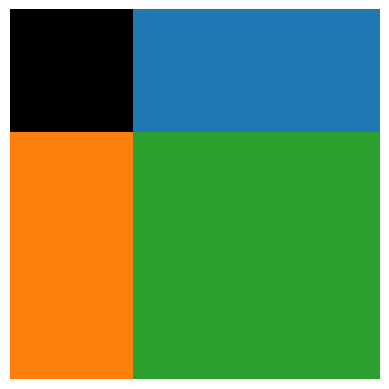

In [40]:
stackview.imshow(silly_image.astype(np.uint32))


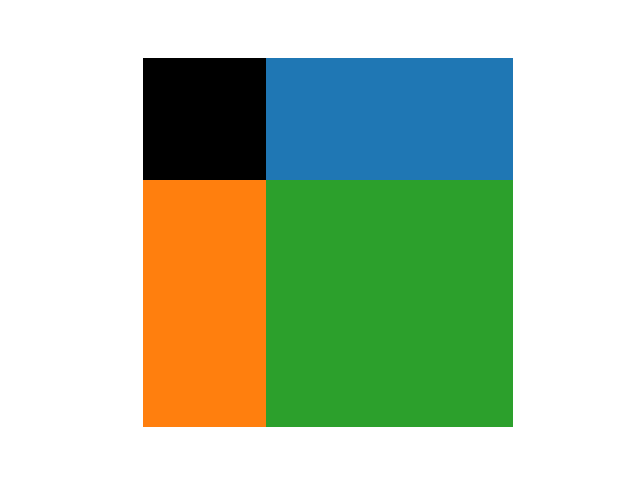

shape (3, 3) 
 dtype uint32 
 size 36.0 B 
 min 0 max 3 n labels 3
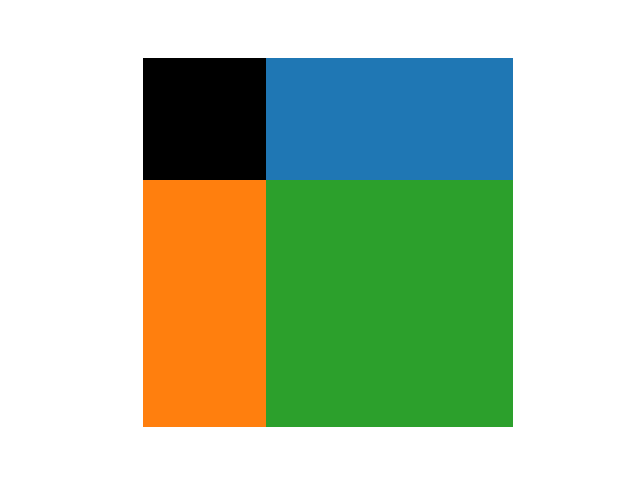

In [41]:
stackview.insight(silly_image.astype(np.uint32))